# Problem

- The data set "DataProject.pk" includes the daily high, low and return for a set of cryptocurrencies. 
- Please look through the data, reporting any issues and suggestions on how to fix them. 

# Solution

Let's first load the data and observe its layout with the head method. The data is organized as a DataFrame with columns (date, asset, value, item) and an integer index (note you will need to change the path here to reflect where you stored DataProject.pk).

In [1]:
import pandas as pd 
import numpy as np
data = pd.read_pickle('DataProject.pk')
data.head()

,date,asset,value,item
0,2020-01-01,ADAUSD,0.033813,daily_high
1,2020-01-01,BTCUSD,7254.330566,daily_high
2,2020-01-01,ETHUSD,132.835358,daily_high
3,2020-01-01,LINKUSD,1.851417,daily_high
4,2020-01-02,ADAUSD,0.033507,daily_high


## Tickers
Using the value_counts() method, we can observe the unique tickers and the number of times they each appear in the DataFrame. The ticker convention is inconsistent. Sometimes, the tickers are specified as "TICKER-USD" and other times as "TICKERUSD".

In [2]:
data['asset'].value_counts()

BTC-USD     633
ETH-USD     633
LINK-USD    633
ADA-USD     632
ADAUSD      362
BTCUSD      362
ETHUSD      362
LINKUSD     362
Name: asset, dtype: int64

Let's make the tickers consistent for ease of use. We can simply make them all "TICKER", dropping the USD. 

In [3]:
data['asset']=data['asset'].map(lambda x: x.replace('-USD','').replace('USD',''))
data['asset'].value_counts()

BTC     995
ETH     995
LINK    995
ADA     994
Name: asset, dtype: int64

## Dates
The dates are specified as strings. 

In [4]:
type(data['date'].values[0])

str

Let's first convert all the dates to timestamps.

In [5]:
data['date'] = pd.DatetimeIndex(data['date'])

Checking the start and end dates, we can see that the data spans the year 2020.

In [6]:
start_dt = data['date'].min()
end_dt = data['date'].max()
print ("Date Range: %s --> %s"%(start_dt,end_dt))

Date Range: 2020-01-01 00:00:00 --> 2020-12-31 00:00:00


Let's quickly perform a consistency check for duplicate values. The data set should only include 1 value for each (date,asset,item) and below confirms that this is so. 

In [7]:
data.groupby(['date','asset','item']).count().max()

value    1
dtype: int64

Often, it's more convenient to work with a MultiIndex DataFrame with dates in the index and (Item, ticker) in the columns. Let's convert to that structure.

In [8]:
data = data.pivot_table(index='date',columns=['asset','item'],values='value').swaplevel(0,1,axis=1).sort_index(axis=1)
data.head()

item       daily_high                                    daily_low  \
asset             ADA          BTC         ETH      LINK       ADA   
date                                                                 
2020-01-01   0.033813  7254.330566  132.835358  1.851417  0.032704   
2020-01-02   0.033507  7212.155273  130.820038  1.816882  0.032448   
2020-01-03   0.034427  7413.715332  134.554016  1.826534  0.032491   
2020-01-04   0.034685  7427.385742  136.052719  1.851112  0.033872   
2020-01-05   0.035356  7544.497070  139.410202  1.855229  0.034545   

item                                        daily_ret                       
asset               BTC       ETH      LINK       ADA    BTC    ETH   LINK  
date                                                                        
2020-01-01  7174.944336  1.291983  1.763420       NaN -999.0 -999.0 -999.0  
2020-01-02  6935.270020  1.269549  1.721658 -0.021131 -999.0 -999.0 -999.0  
2020-01-03  6914.996094  1.264900  1.712578  0.043632 -999.0 -999.0 -999.0  
2020-01-04  7309.514160  1.330406  1.789742  0.012142 -999.0 -999.0 -999.0  
2020-01-05  7400.535645  1.350456  1.803682  0.003642 -999.0 -999.0 -999.0

Now, let's reindex the DataFrame to include every possible date between the start and end dates. This will allow us to spot any missing data more easily in plots. 

In [9]:
new_index = pd.date_range(start_dt,end_dt,freq='D')
assert np.all([x in new_index for x in data.index]) # confrim new_index contains old dates
data = data.reindex(new_index)

## Counts
We should check the counts of each data item through time to spot any holes

In [10]:
counts = data.groupby(level=0,axis=1).count()

The daily_high looks like it's missinig all data on 5 dates 4/17, 10/9, 10/12, and 10/13. This seems like an error as cryptocurrencies trade 24/7.

<AxesSubplot:>

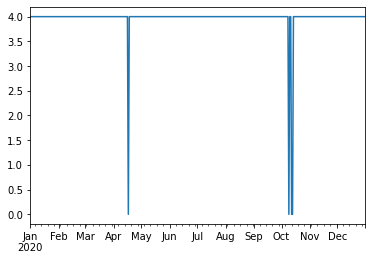

In [11]:
counts['daily_high'].plot()

In [12]:
counts['daily_high'][counts['daily_high']==0]

2020-04-17    0
2020-10-09    0
2020-10-12    0
2020-10-13    0
Name: daily_high, dtype: int64

Observing the counts for daily_ret, we can see that it is missing data on the same dates as daily_high which again seems like an error.

<AxesSubplot:>

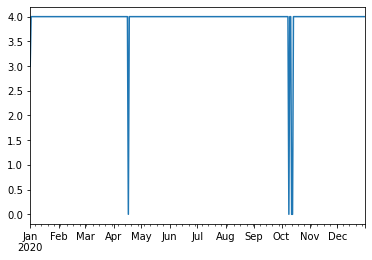

In [13]:
counts['daily_ret'].plot()

In [14]:
counts['daily_ret'][counts['daily_ret']==0]

2020-04-17    0
2020-10-09    0
2020-10-12    0
2020-10-13    0
Name: daily_ret, dtype: int64

The counts for daily_low show that it is entirely missing data between from 7/2 to 9/30. Moreover, it is missing data on the same 4 days as daily_ret and daily_high.

<AxesSubplot:>

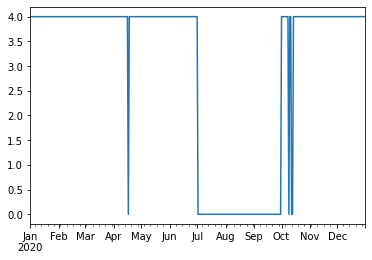

In [15]:
counts['daily_low'].plot()

In [16]:
counts['daily_low'][counts['daily_low']==0]

2020-04-17    0
2020-07-02    0
2020-07-03    0
2020-07-04    0
2020-07-05    0
             ..
2020-09-29    0
2020-09-30    0
2020-10-09    0
2020-10-12    0
2020-10-13    0
Name: daily_low, Length: 95, dtype: int64

## Summary Stats
Let's print some summary stats for the daily_high and daily_low to detect any outliers. The DataFrame describe() method can be useful for this. 

In [17]:
stats = data.describe()

The daily_high summary stats seem relatively normal. One thing that jumps out immediately on the daily_low summary stats is the wide range for ETH The minimum value is 0.95 and the maximum is 726. This seems like an error and especailly so when contrasted with the daily_high summary stats which show a more reasonable range of values for ETH.

In [18]:
stats['daily_high']

asset,ADA,BTC,ETH,LINK
count,362.000000,362.000000,362.000000,362.000000
mean,0.089687,11306.644431,314.841528,7.728245
std,0.043156,4399.843207,148.013107,4.783576
min,0.025993,2836.645020,116.021622,1.816882
25%,0.051493,9037.108887,205.904774,3.825582
50%,0.087889,9836.208496,248.325653,4.896292
75%,0.124195,11799.821533,399.151688,12.326414
max,0.196170,29244.876953,754.303223,19.851822


In [19]:
stats['daily_low']

asset,ADA,BTC,ETH,LINK
count,271.000000,271.000000,271.000000,271.000000
mean,0.073226,10982.624732,184.754110,5.996121
std,0.039605,4751.865495,227.522378,4.040619
min,0.019130,4106.980957,0.951843,1.506868
25%,0.042232,8310.858398,1.721006,3.054004
50%,0.057607,9300.430664,2.300528,3.926330
75%,0.099543,12854.064941,379.422623,10.546959
max,0.176594,28201.992188,726.511902,15.005792


Plotting the ETH daily_low below confirms that this is likely an issue with the data prior to 6/2/2020 (as crazy as ETH returns have been, do not recall it having a +100x return on a single day in 2020 but this can be confirmed with 3rd party resources).

<AxesSubplot:>

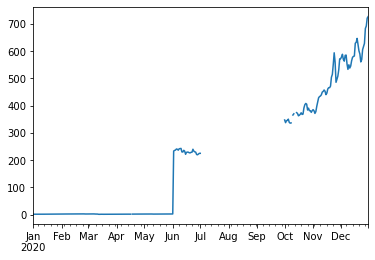

In [20]:
data['daily_low']['ETH'].plot()

Let's observe the values around the spike below. It almost looks like the daily_low values for ETH prior to 6/2 were divided by 100.

In [21]:
data['daily_low']['ETH'].loc['20200525':'20200605']

2020-05-25      2.006676
2020-05-26      2.002643
2020-05-27      2.017851
2020-05-28      2.062427
2020-05-29      2.182381
2020-05-30      2.187445
2020-05-31      2.300528
2020-06-01      2.304881
2020-06-02    233.225296
2020-06-03    235.464447
2020-06-04    236.765305
2020-06-05    240.682053
Freq: D, Name: ETH, dtype: float64

Plotting the values below for daily_low and daily_high below further suggests that this is likely the case. The daily_low for ETH mirrors the shape of the daily_high for ETH but looks smaller by a factor of ~100x. So one way to fix this issue is by simply multiplying ETH daily_low before 6/2/2020 by 100x.

<AxesSubplot:>

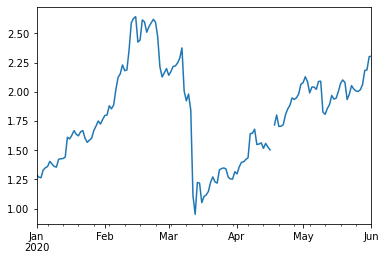

In [22]:
data['daily_low']['ETH'].loc[:'20200601'].plot()

<AxesSubplot:>

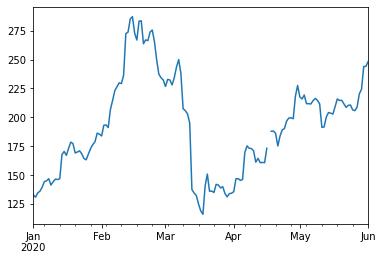

In [23]:
data['daily_high']['ETH'].loc[:'20200601'].plot()

Summary stats for daily_ret show the biggests issue is that some of the values are -999, which is definitely an error.

In [24]:
stats['daily_ret']

asset,ADA,BTC,ETH,LINK
count,361.000000,362.000000,362.000000,362.000000
mean,0.006433,-85.545851,-168.335241,-333.915569
std,0.058148,279.933124,374.462337,471.912665
min,-0.395672,-999.000000,-999.000000,-999.000000
25%,-0.022893,-0.015206,-0.041088,-999.000000
50%,0.004557,0.001046,-0.003846,-0.028047
75%,0.034885,0.015859,0.022562,0.019937
max,0.201887,0.181878,0.189404,0.279402


Let's plot the count of -999 through time. It looks like -999 appears for 3/4 tickers initially and then gradaully falls to zero of the tickers.

<AxesSubplot:>

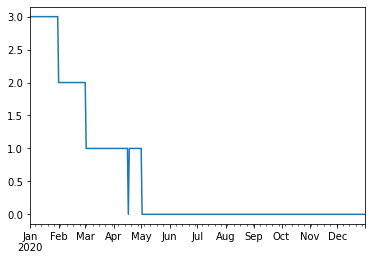

In [25]:
ct = (data['daily_ret']==-999).sum(1)
ct.plot()

Let's remove -999 as it is an error.

In [26]:
data['daily_ret']=data['daily_ret'].where(data['daily_ret']!=-999)

The cleaned up stats on daily_ret below look much more reasonable. There are some large moves, but 2020 was also a very volatile year and crypto is a very volatile asset class. 

In [27]:
data['daily_ret'].describe()

asset,ADA,BTC,ETH,LINK
count,361.000000,331.000000,301.000000,241.000000
mean,0.006433,0.004236,0.005457,0.006490
std,0.058148,0.038714,0.051057,0.063583
min,-0.395672,-0.371695,-0.423472,-0.193371
25%,-0.022893,-0.009371,-0.016506,-0.027785
50%,0.004557,0.002924,0.005961,0.001683
75%,0.034885,0.017321,0.029547,0.036618
max,0.201887,0.181878,0.189404,0.279402


Another useful approach in this section is to look at time-series plots. Such plots would have caught the issues above as well. These are also great for detecting any abnormal breaks, jumps or shifts in the data. For instance, we could plot the max / min daily returns below. These plots give us additional confidence that the extreme returns values are not likely errors as they typically cluster around when COVID hit, and we expect large moves there.

<AxesSubplot:>

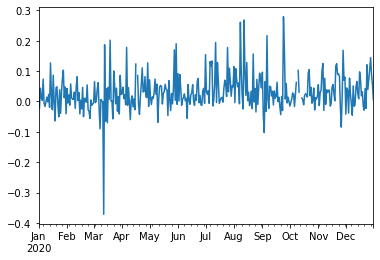

In [28]:
data['daily_ret'].max(1).plot()

<AxesSubplot:>

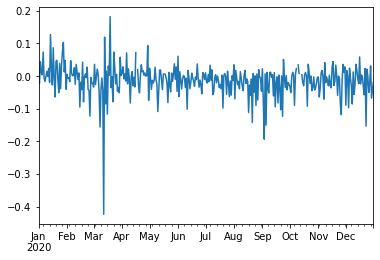

In [29]:
data['daily_ret'].min(1).plot()

## Consistency
One simple consistency check we can run is to ensure that daily_high is less than daily_low for all data points. Below shows that this is not the case for BTC on one day. 

In [30]:
check = data['daily_high'] < data['daily_low']
check.sum()

asset
ADA     0
BTC     1
ETH     0
LINK    0
dtype: int64

Below we check when this happens and show it is on 3/15/2020.

In [31]:
check[check['BTC']]

asset,ADA,BTC,ETH,LINK
2020-03-15,False,True,False,False


Let's observe the high and low for BTC around that date. It looks like the high abrutply fell to to 2.8K on 3/15/2020 from ~5K. This seems like an error and especailly so since it is lower than the low on that day.

In [32]:
btc = {}
btc['high']=data['daily_high'].loc['20200310':'20200320','BTC']
btc['low']=data['daily_low'].loc['20200310':'20200320','BTC']
btc = pd.DataFrame(btc)
btc

,high,low
2020-03-10,8136.945312,7814.763184
2020-03-11,7950.814453,7642.812500
2020-03-12,7929.116211,4860.354004
2020-03-13,5838.114746,4106.980957
2020-03-14,5625.226562,5125.069336
2020-03-15,2836.645020,5169.283203
2020-03-16,5385.229492,4575.357910
2020-03-17,5371.348633,4981.909180
2020-03-18,5331.833984,5069.335938
2020-03-19,6329.735840,5236.968750


Let's null this value out

In [33]:
data.loc['20200315',('daily_high','BTC')]=np.nan

Another consistency check we can run is to ensure that the daily_ret is bounded by the max possible return (daily_high / daily_low.shift() - 1) and the min possible return (daily_low / daily_high.shift() - 1). Below we confirm that this is so.

In [34]:
max_ret = data['daily_high'] / data['daily_low'].shift() - 1
min_ret = data['daily_low'] / data['daily_high'].shift() - 1

In [35]:
max_break = (data['daily_ret'] > max_ret)
min_break = (data['daily_ret'] < min_ret)

In [36]:
max_break.sum()

asset
ADA     0
BTC     0
ETH     0
LINK    0
dtype: int64

In [37]:
min_break.sum()

asset
ADA     0
BTC     0
ETH     0
LINK    0
dtype: int64